In [35]:
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession 
from pyspark.ml.stat import Correlation
import pyspark.sql.functions as F
from pyspark.sql.functions import abs as pyspark_abs

conf = pyspark.SparkConf().setAppName('appName').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)

In [36]:
spark

In [37]:
df = spark.read.csv("scaled_data.csv", inferSchema=True,header=True)

In [38]:
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import monotonically_increasing_id
import matplotlib.pyplot as plt
from pyspark.ml.regression import GBTRegressor
import numpy as np


In [39]:
# Vector Assembler

assembler = VectorAssembler(inputCols=['Production','Annual_Rainfall','Fertilizer','Pesticide','Area','Crop','Crop_Year','Season','State'],outputCol='features')
output= assembler.transform(df)
final_data=output.select('features','Yield')
final_data.head(5)

[Row(features=DenseVector([-0.0829, 1.4087, 0.3399, 1.0518, 0.7874, 0.0, 1997.0, 4.0, 2.0]), Yield=0.796086957),
 Row(features=DenseVector([-0.7026, 1.4087, -0.6966, -0.6273, -0.6538, 1.0, 1997.0, 1.0, 2.0]), Yield=0.710434783),
 Row(features=DenseVector([-0.7567, 1.4087, -0.7868, -0.7733, -0.7791, 8.0, 1997.0, 1.0, 2.0]), Yield=0.3462870368),
 Row(features=DenseVector([1.7688, 1.4087, -0.4957, -0.3019, -0.3745, 9.0, 1997.0, 4.0, 2.0]), Yield=3.0946403166000005),
 Row(features=DenseVector([-0.749, 1.4087, -0.7722, -0.7498, -0.7589, 11.0, 1997.0, 1.0, 2.0]), Yield=0.420909091)]

In [18]:
# Setting the tolerance level

tolerance = 1.5

# Model 1

In [19]:
# Splitting the data and training the model

train_data1,test_data1=final_data.randomSplit([0.7,0.3], seed=13) 
gbt1 = GBTRegressor(featuresCol='features', labelCol='Yield')
model4 = gbt1.fit(train_data1)

In [20]:
# Combining actual and predicted yield in a single PySpark dataframe

unlabeled_data4=test_data1.select('features')
preds4 = model4.transform(unlabeled_data4)
preds4 = preds4.select('prediction')
actual4 = test_data1.select('Yield')
preds4 = preds4.withColumn("index", monotonically_increasing_id())
actual4 = actual4.withColumn("index", monotonically_increasing_id())
preds_labels4 = preds4.join(actual4, on="index").drop("index")


In [22]:
# Evaluating the results using accuracy, R2 Score, RMSE and MAE metrics

evaluator4 = RegressionEvaluator(labelCol="Yield", predictionCol="prediction", metricName="r2")
r24 = evaluator4.evaluate(preds_labels4)
evaluator4.setMetricName("mse")
mse4 = evaluator4.evaluate(preds_labels4)
evaluator4.setMetricName("mae")
mae4 = evaluator4.evaluate(preds_labels4)

within_tolerance4 = preds_labels4.filter(pyspark_abs(preds_labels4.prediction - preds_labels4.Yield) <= tolerance)
correct_predictions4 = within_tolerance4.count()
total_predictions4 = preds_labels4.count()
accuracy4 = (correct_predictions4 / total_predictions4) * 100

print("Accuracy within the", tolerance, "tolerance =", accuracy4)
print('R2 Score on Testing Data:',r24)
print('Root Mean Squared Error on Testing Data:',(mse4**(1/2)))
print('Mean Absolute Error on Testing Data:',mae4)

Accuracy within the 1.5 tolerance = 99.33139036516371
R2 Score on Testing Data: 0.8255462278133413
Root Mean Squared Error on Testing Data: 0.426184369276082
Mean Absolute Error on Testing Data: 0.292408722650758


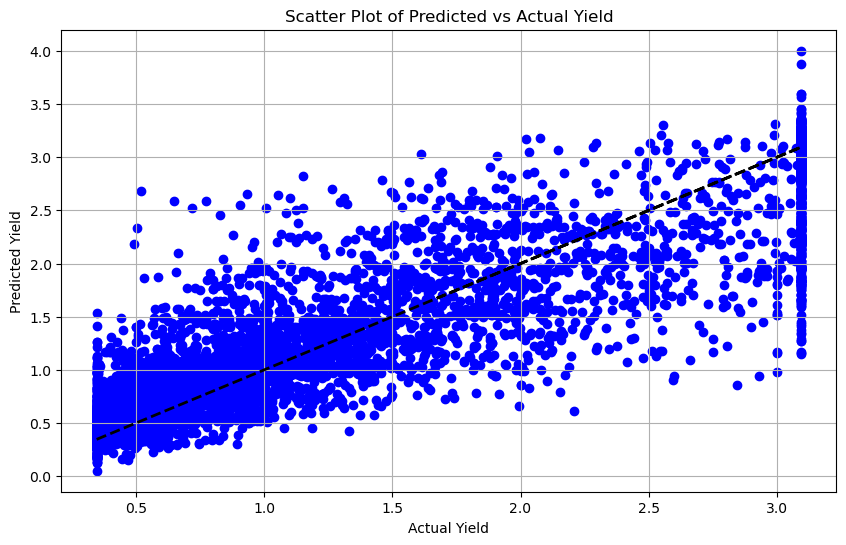

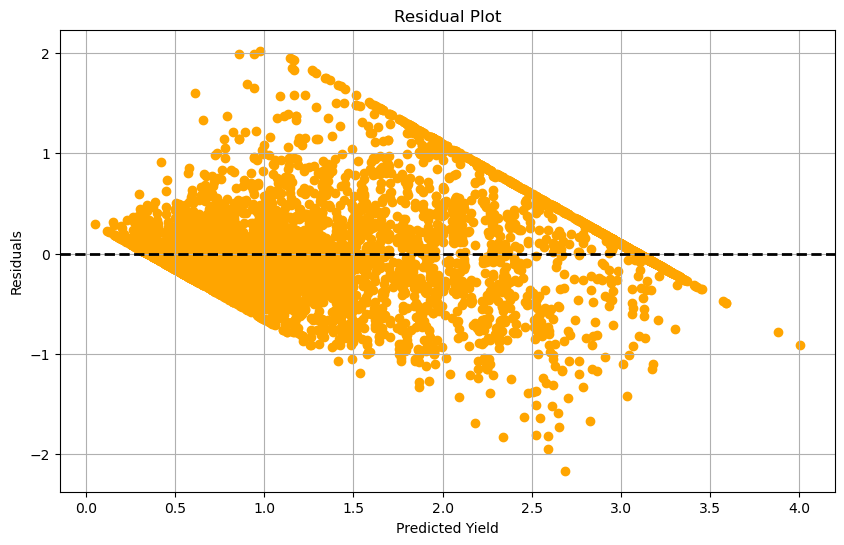

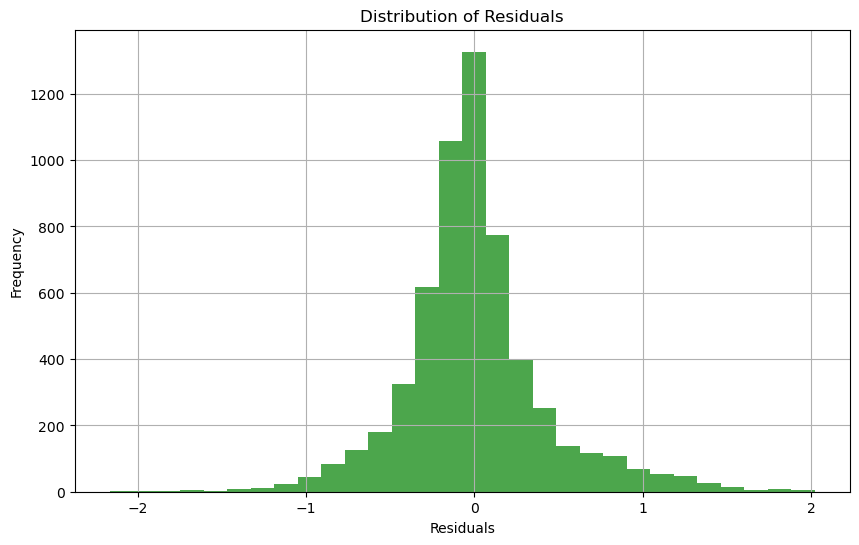

In [25]:
# Visualization of results ---------------------------->

# Scatter plot of Predicted vs Actual values
plt.figure(figsize=(10, 6))
plt.scatter(preds_labels4.select("Yield").toPandas(),preds_labels4.select("prediction").toPandas(), color='blue')
plt.plot(preds_labels4.select("Yield").toPandas(), preds_labels4.select("Yield").toPandas(), 'k--', lw=2)  # this part plots a diagonal line that represents perfect predictions
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title('Scatter Plot of Predicted vs Actual Yield')
plt.grid(True)
plt.show()

# Residual Plot
residuals4 = np.array(preds_labels4.select("Yield").toPandas()) - np.array(preds_labels4.select("prediction").toPandas())
plt.figure(figsize=(10, 6))
plt.scatter(preds_labels4.select("prediction").toPandas(), residuals4, color='orange')
plt.xlabel('Predicted Yield')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.axhline(y=0, color='k', linestyle='--', linewidth=2)
plt.show()

# Distribution of Residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals4, bins=30, color='green', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True)
plt.show()

# Model 2

In [26]:
# Splitting the data and training the model

train_data2,test_data2=final_data.randomSplit([0.8,0.2], seed=20) 
gbt2 = GBTRegressor(featuresCol='features', labelCol='Yield')
model5 = gbt2.fit(train_data2)

In [27]:
# Combining actual and predicted yield in a single PySpark dataframe

unlabeled_data5=test_data2.select('features')
preds5 = model5.transform(unlabeled_data5)
preds5 = preds5.select('prediction')
actual5 = test_data2.select('Yield')
preds5 = preds5.withColumn("index", monotonically_increasing_id())
actual5 = actual5.withColumn("index", monotonically_increasing_id())
preds_labels5 = preds5.join(actual5, on="index").drop("index")

In [28]:
# Evaluating the results using accuracy, R2 Score, RMSE and MAE metrics

evaluator5 = RegressionEvaluator(labelCol="Yield", predictionCol="prediction", metricName="r2")
r25 = evaluator5.evaluate(preds_labels5)
evaluator5.setMetricName("mse")
mse5 = evaluator5.evaluate(preds_labels5)
evaluator5.setMetricName("mae")
mae5 = evaluator5.evaluate(preds_labels5)

within_tolerance5 = preds_labels5.filter(pyspark_abs(preds_labels5.prediction - preds_labels5.Yield) <= tolerance)
correct_predictions5 = within_tolerance5.count()
total_predictions5 = preds_labels5.count()
accuracy5 = (correct_predictions5 / total_predictions5) * 100

print("Accuracy within the", tolerance, "tolerance =", accuracy5)
print('R2 Score on Testing Data:',r25)
print('Root Mean Squared Error on Testing Data:',(mse5**(1/2)))
print('Mean Absolute Error on Testing Data:',mae5)

Accuracy within the 1.5 tolerance = 99.43877551020408
R2 Score on Testing Data: 0.8385142039061627
Root Mean Squared Error on Testing Data: 0.40885347890148377
Mean Absolute Error on Testing Data: 0.2819959545777835


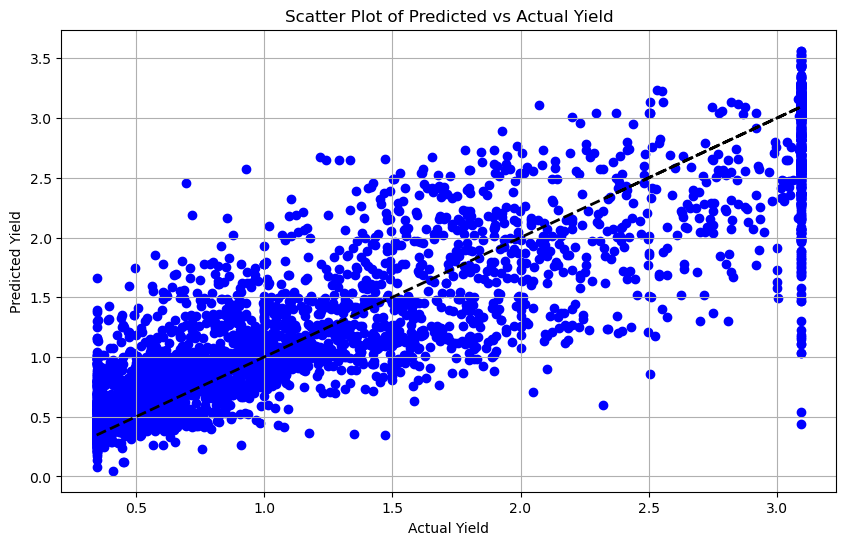

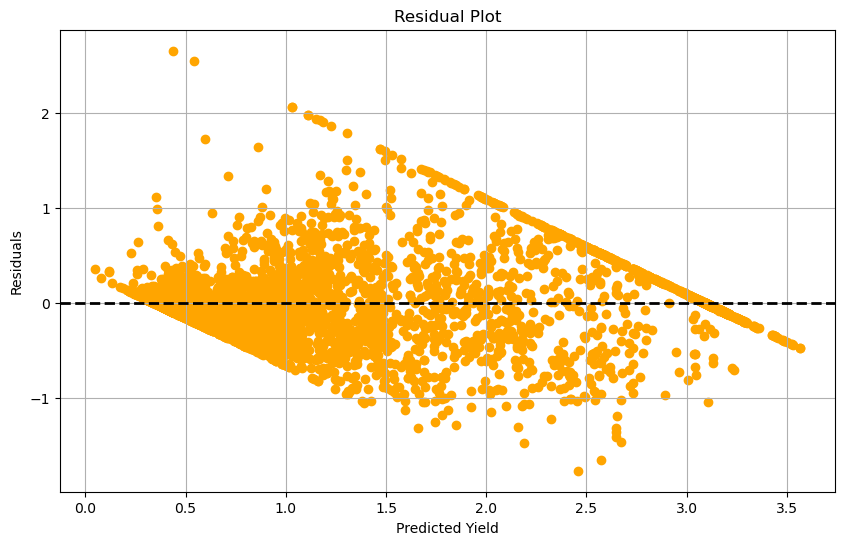

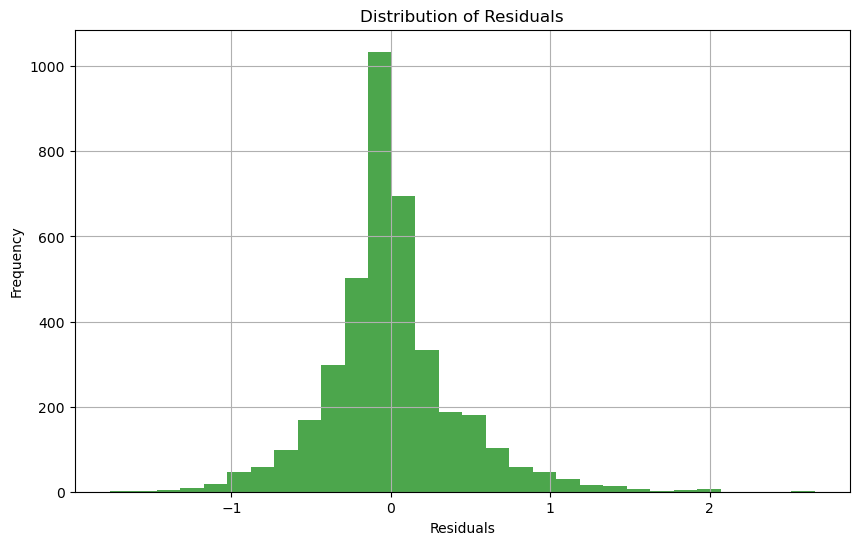

In [29]:
# Visualization of results ---------------------------->

# Scatter plot of Predicted vs Actual values
plt.figure(figsize=(10, 6))
plt.scatter(preds_labels5.select("Yield").toPandas(),preds_labels5.select("prediction").toPandas(), color='blue')
plt.plot(preds_labels5.select("Yield").toPandas(), preds_labels5.select("Yield").toPandas(), 'k--', lw=2)  # this part plots a diagonal line that represents perfect predictions
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title('Scatter Plot of Predicted vs Actual Yield')
plt.grid(True)
plt.show()

# Residual Plot
residuals5 = np.array(preds_labels5.select("Yield").toPandas()) - np.array(preds_labels5.select("prediction").toPandas())
plt.figure(figsize=(10, 6))
plt.scatter(preds_labels5.select("prediction").toPandas(), residuals5, color='orange')
plt.xlabel('Predicted Yield')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.axhline(y=0, color='k', linestyle='--', linewidth=2)
plt.show()

# Distribution of Residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals5, bins=30, color='green', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True)
plt.show()

# Model 3

In [30]:
# Splitting the data and training the model

train_data3,test_data3=final_data.randomSplit([0.9,0.1], seed=20)
gbt3 = GBTRegressor(featuresCol='features', labelCol='Yield')
model6 = gbt3.fit(train_data3)

In [31]:
# Combining actual and predicted yield in a single PySpark dataframe

unlabeled_data6 =test_data3.select('features')
preds6 = model6.transform(unlabeled_data6)
preds6 = preds6.select('prediction')
actual6 = test_data3.select('Yield')
preds6 = preds6.withColumn("index", monotonically_increasing_id())
actual6 = actual6.withColumn("index", monotonically_increasing_id())
preds_labels6 = preds6.join(actual6, on="index").drop("index")


In [32]:
# Evaluating the results using accuracy, R2 Score, RMSE and MAE metricsw

evaluator6 = RegressionEvaluator(labelCol="Yield", predictionCol="prediction", metricName="r2")
r26 = evaluator6.evaluate(preds_labels6)
evaluator6.setMetricName("mse")
mse6 = evaluator6.evaluate(preds_labels6)
evaluator6.setMetricName("mae")
mae6 = evaluator6.evaluate(preds_labels6)

within_tolerance6 = preds_labels6.filter(pyspark_abs(preds_labels6.prediction - preds_labels6.Yield) <= tolerance)
correct_predictions6 = within_tolerance6.count()
total_predictions6 = preds_labels6.count()
accuracy6 = (correct_predictions6 / total_predictions6) * 100

print("Accuracy within the", tolerance, "tolerance =", accuracy6)
print('R2 Score on Testing Data:',r26)
print('Root Mean Squared Error on Testing Data:',(mse6**(1/2)))
print('Mean Absolute Error on Testing Data:',mae6)

Accuracy within the 1.5 tolerance = 99.21011058451816
R2 Score on Testing Data: 0.8259354744932186
Root Mean Squared Error on Testing Data: 0.4200063032635055
Mean Absolute Error on Testing Data: 0.2907647292537554


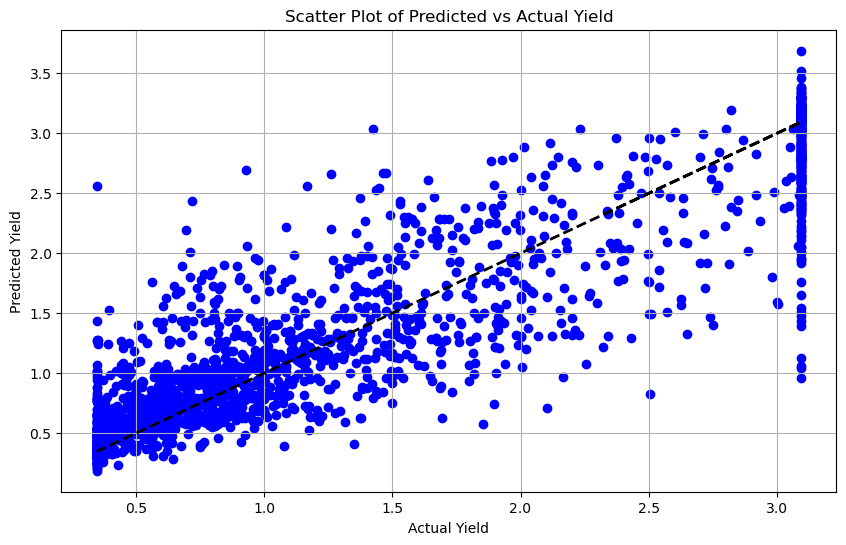

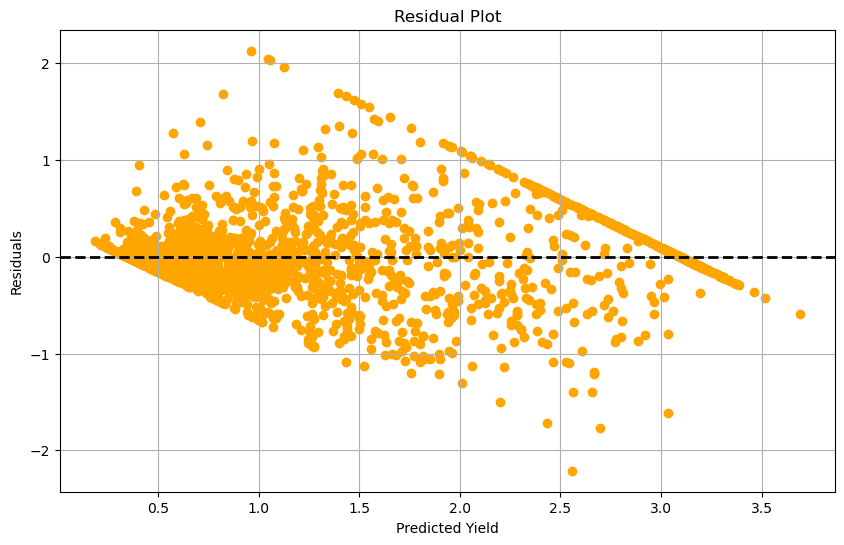

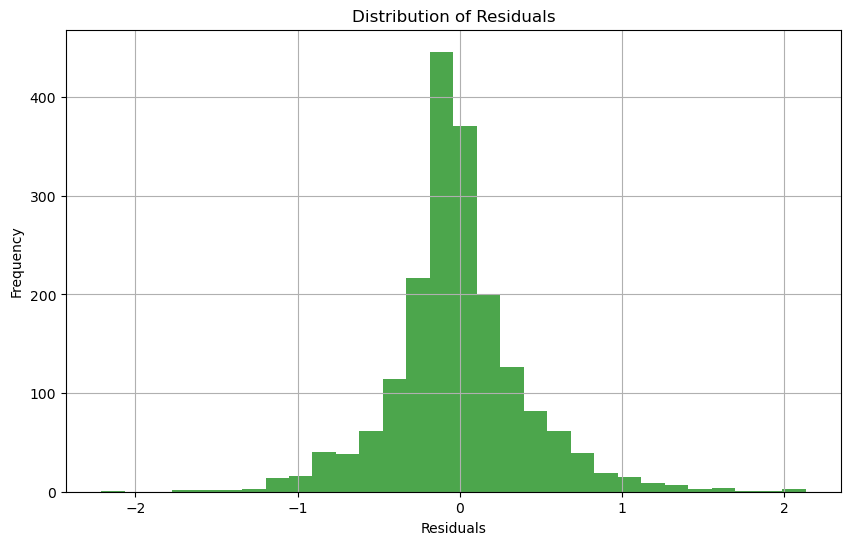

In [33]:
# Visualization of results ---------------------------->

# Scatter plot of Predicted vs Actual values
plt.figure(figsize=(10, 6))
plt.scatter(preds_labels6.select("Yield").toPandas(),preds_labels6.select("prediction").toPandas(), color='blue')
plt.plot(preds_labels6.select("Yield").toPandas(), preds_labels6.select("Yield").toPandas(), 'k--', lw=2)  # this part plots a diagonal line that represents perfect predictions
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title('Scatter Plot of Predicted vs Actual Yield')
plt.grid(True)
plt.show()

# Residual Plot
residuals6 = np.array(preds_labels6.select("Yield").toPandas()) - np.array(preds_labels6.select("prediction").toPandas())
plt.figure(figsize=(10, 6))
plt.scatter(preds_labels6.select("prediction").toPandas(), residuals6, color='orange')
plt.xlabel('Predicted Yield')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.axhline(y=0, color='k', linestyle='--', linewidth=2)
plt.show()

# Distribution of Residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals6, bins=30, color='green', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True)
plt.show()

In [34]:
sc.stop()